# 시작

In [119]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


# 데이터 불러오기 & 조정 함수

In [120]:
def load_data(file):
    path = os.getenv('HOME') + '/aiffel/stock_prediction/data'
    file_path = os.path.join(path, file)
    data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    print('{} 파일을 불러왔습니다.'.format(file))
    print(data)
    if file=='105560.KS.csv': # 입력 오류로 보이는 데이터 조정, KB금융지주
        data[data['Close'] > 3000000] /= 100
    return data


def refine_data(data):
    '''
    공휴일 등 주가가 없는 날이 있으므로 연속된 날짜 INDEX를 가진 데이터를 생성
    주가가 없는 날은 보간법으로 값을 채움
    '''
    start, end = data.index[0], data.index[-1]
    new_data = pd.DataFrame({}, index=pd.date_range(start=start, end=end)).join(data['Close'])
    new_data = new_data.interpolate(method='time')
    print('데이터를 조정하였습니다')
    print(new_data[:10]) # 열흘치를 출력하면 반드시 주말을 볼 수 있으므로
    return new_data['Close']

# 데이터의 안정성 확인 함수

In [121]:
# LMS 함수 사용
def plot_rolling_statistics(timeseries, window=365):
    '''
    주식가격의 주기를 365일로 추정하고 window를 365로 설정
    '''
    mean = timeseries.rolling(window=window).mean()
    std = timeseries.rolling(window=window).std() 
    
    plt.plot(timeseries, color='blue',label='Original')    
    plt.plot(mean, color='red', label='Rolling Mean')
    plt.plot(std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# Augmented Dickey Fuller Test 함수

In [122]:
# LMS 함수 사용
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Seasonal Decompose 함수

In [123]:
def seasonal_decomposed_data(timeseries, period=365):
    '''
    주식가격의 주기를 365일로 추정하고 period를 365로 설정
    '''
    decomposed = seasonal_decompose(timeseries, period=period)
    
    trend = decomposed.trend.dropna()
    seasonal = decomposed.seasonal.dropna()
    residual = decomposed.resid.dropna()
    
    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return trend, seasonal, residual

# ARIMA함수

In [124]:
def find_ARIMA_p(timeseries):
    '''
    ARIMA의 p를 추정하기 위한 그래프
    '''
    plot_pacf(timeseries)
    plt.show()
    
    
def find_ARIMA_d(timeseries):
    '''
    ARIMA의 d를 추정하기 위한 그래프
    '''
    diff_data = timeseries
    for i in range(3):
        diff_data = diff_data.diff(periods=1).iloc[1:]
        diff_data.plot(title='Difference {}'.format(i+1))
        plt.show()
        augmented_dickey_fuller_test(diff_data)
        
        
def find_ARIMA_q(timeseries):
    '''
    ARIMA의 q를 추정하기 위한 그래프
    '''
    plot_acf(timeseries)
    plt.show()

In [125]:
def split_train_test(timeseries):
    train_size = int(len(timeseries)*0.9)
    train_data, test_data = timeseries[:train_size], timeseries[train_size:]
    print('훈련데이터 {}개, 시험데이터 {}개'.format(len(train_data), len(test_data)))
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(timeseries, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    
    return train_data, test_data

In [126]:
def train_model(data, p, d, q):
    '''
    ARIMA를 훈련하고 predict그래프를 그림
    '''
    model = ARIMA(data, order=(p, d, q))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    fitted_m.plot_predict()
    plt.show()
    return fitted_m

# 결과 확인 함수

In [127]:
def show_predict(model, train_data, test_data, logged=False):
    fc, se, conf = model.forecast(len(test_data), alpha=0.05)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf[:, 0], index=test_data.index)
    upper_series = pd.Series(conf[:, 1], index=test_data.index)

    # Plot
    plt.figure(figsize=(9,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    if logged:
        test_data = np.exp(test_data)
        fc = np.exp(fc)
        
    mse = mean_squared_error(test_data, fc)
    print('MSE: ', mse)

    mae = mean_absolute_error(test_data, fc)
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(test_data, fc))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
    print('MAPE: {:.2f}%'.format(mape*100))

# 메인

## 삼성전자

In [128]:
file = '005930.KS.csv' # 삼성전자
use_log = True
data = load_data(file)

005930.KS.csv 파일을 불러왔습니다.
               Open     High      Low    Close     Adj Close      Volume
Date                                                                    
2000-01-04   6000.0   6110.0   5660.0   6110.0   4761.183105  74195000.0
2000-01-05   5800.0   6060.0   5520.0   5580.0   4348.184082  74680000.0
2000-01-06   5750.0   5780.0   5580.0   5620.0   4379.354004  54390000.0
2000-01-07   5560.0   5670.0   5360.0   5540.0   4317.015625  40305000.0
2000-01-10   5600.0   5770.0   5580.0   5770.0   4496.240723  46880000.0
...             ...      ...      ...      ...           ...         ...
2021-02-17  83900.0  84200.0  83000.0  83200.0  83200.000000  18307735.0
2021-02-18  83200.0  83600.0  82100.0  82100.0  82100.000000  21327683.0
2021-02-19  82300.0  82800.0  81000.0  82600.0  82600.000000  25880879.0
2021-02-22  83800.0  84200.0  82200.0  82200.0  82200.000000  25419886.0
2021-02-23  81200.0  81800.0  81100.0  81700.0  81700.000000   9964592.0

[5315 rows x 6 columns]


In [129]:
data = refine_data(data)
if use_log:
    data = np.log(data)

데이터를 조정하였습니다
                  Close
2000-01-04  6110.000000
2000-01-05  5580.000000
2000-01-06  5620.000000
2000-01-07  5540.000000
2000-01-08  5616.666667
2000-01-09  5693.333333
2000-01-10  5770.000000
2000-01-11  5770.000000
2000-01-12  5720.000000
2000-01-13  5710.000000


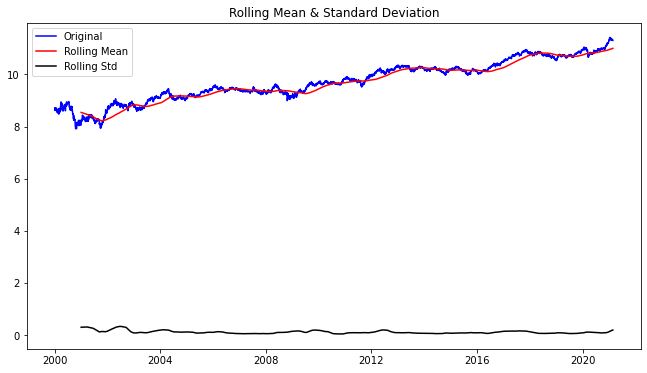

In [130]:
plot_rolling_statistics(data)

In [131]:
augmented_dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                   -0.367966
p-value                           0.915311
#Lags Used                        6.000000
Number of Observations Used    7715.000000
Critical Value (1%)              -3.431198
Critical Value (5%)              -2.861915
Critical Value (10%)             -2.566969
dtype: float64


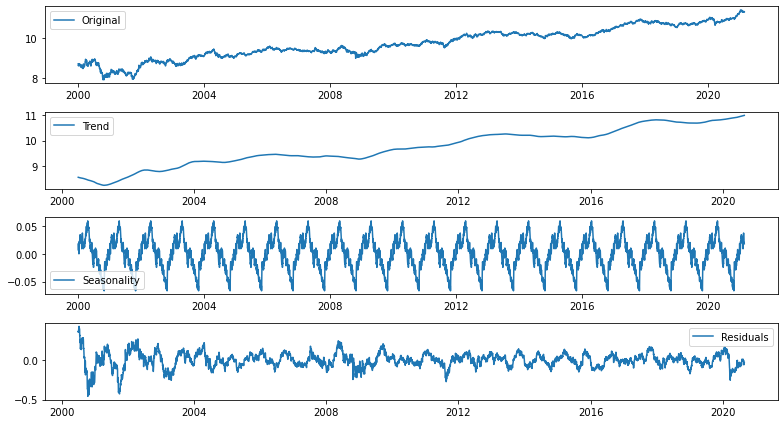

In [132]:
trend_data, seasonal_data, residual_data = seasonal_decomposed_data(data)

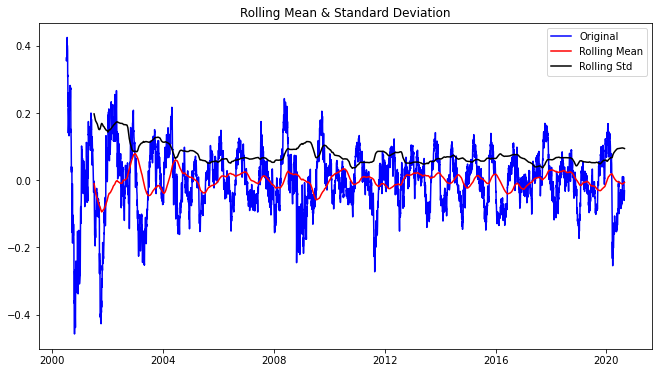

In [133]:
plot_rolling_statistics(residual_data)

In [134]:
augmented_dickey_fuller_test(residual_data)

Results of Dickey-Fuller Test:
Test Statistic                -7.958511e+00
p-value                        2.992032e-12
#Lags Used                     3.500000e+01
Number of Observations Used    7.322000e+03
Critical Value (1%)           -3.431243e+00
Critical Value (5%)           -2.861935e+00
Critical Value (10%)          -2.566980e+00
dtype: float64


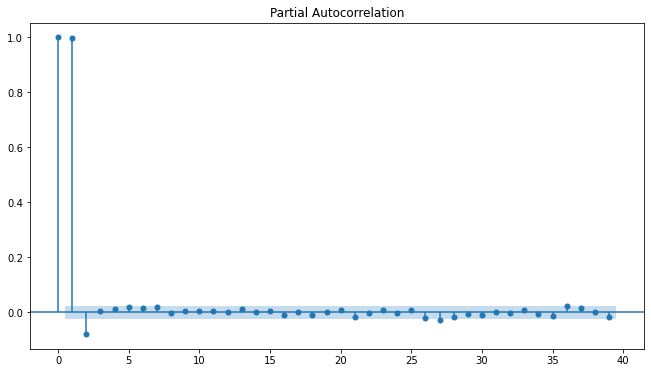

In [135]:
find_ARIMA_p(data)

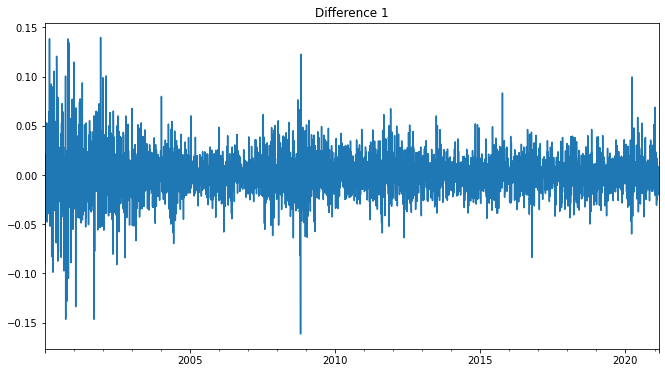

Results of Dickey-Fuller Test:
Test Statistic                  -39.103228
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    7715.000000
Critical Value (1%)              -3.431198
Critical Value (5%)              -2.861915
Critical Value (10%)             -2.566969
dtype: float64


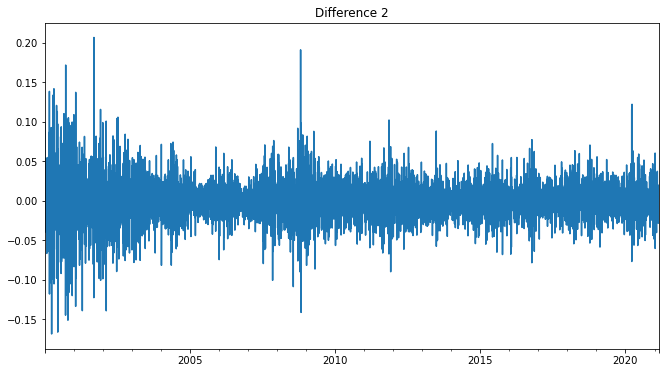

Results of Dickey-Fuller Test:
Test Statistic                  -25.686797
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7683.000000
Critical Value (1%)              -3.431201
Critical Value (5%)              -2.861916
Critical Value (10%)             -2.566970
dtype: float64


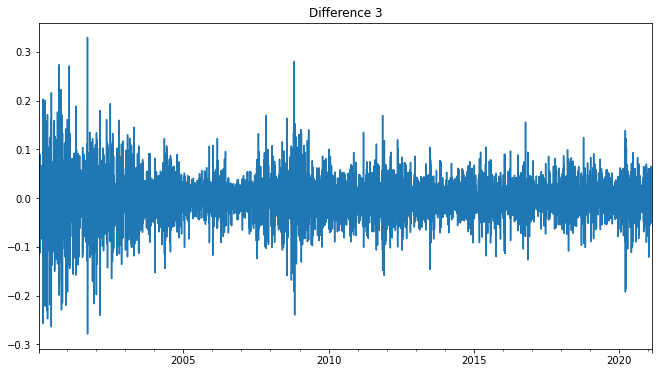

Results of Dickey-Fuller Test:
Test Statistic                  -32.465633
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7682.000000
Critical Value (1%)              -3.431202
Critical Value (5%)              -2.861916
Critical Value (10%)             -2.566970
dtype: float64


In [136]:
find_ARIMA_d(data)

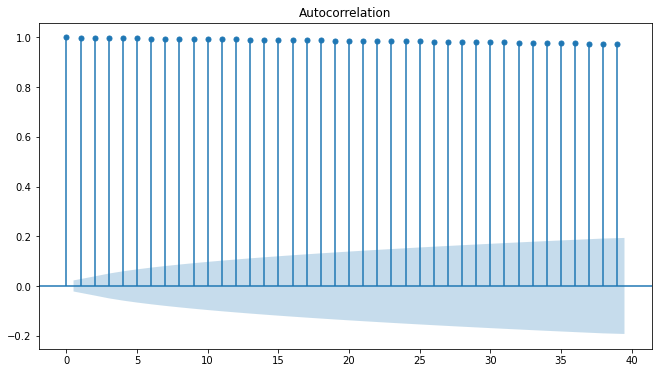

In [137]:
find_ARIMA_q(data)

훈련데이터 6949개, 시험데이터 773개


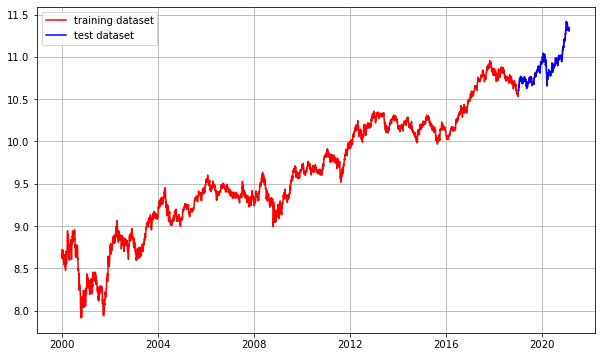

In [138]:
train_data, test_data = split_train_test(data)

/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6948
Model:                 ARIMA(1, 1, 0)   Log Likelihood               18265.784
Method:                       css-mle   S.D. of innovations              0.017
Date:                Wed, 24 Feb 2021   AIC                         -36525.567
Time:                        14:30:03   BIC                         -36505.029
Sample:                    01-05-2000   HQIC                        -36518.487
                         - 01-12-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.141      0.254      -0.000       0.001
ar.L1.D.Close     0.1148      0.012      9.610      0.000       0.091       0.138
                                    Root

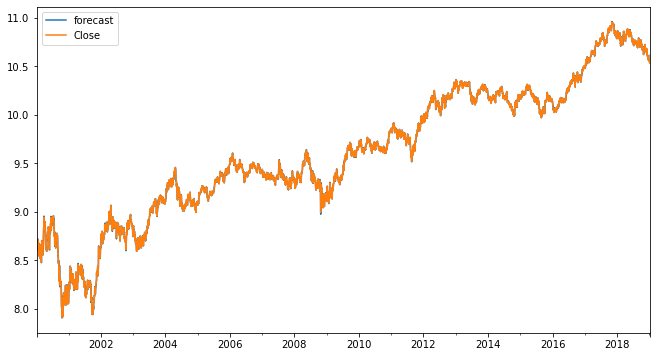

In [139]:
fitted_m = train_model(train_data, 1, 1, 0)

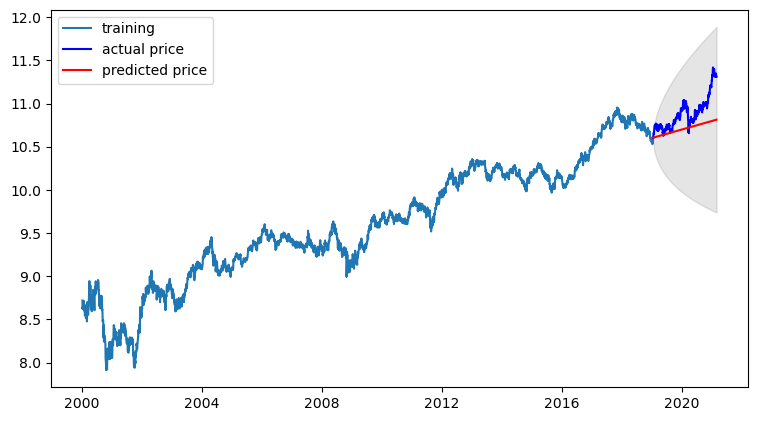

MSE:  174231177.00791466
MAE:  9587.235655862522
RMSE:  13199.665791523461
MAPE: 15.50%


In [140]:
show_predict(fitted_m, train_data, test_data, use_log)

## 현대차

In [141]:
file = 'HYMTF.csv' # 현대차
use_log = True
data = load_data(file)

HYMTF.csv 파일을 불러왔습니다.
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2009-02-13   6.400000   6.400000   6.400000   6.400000   6.400000       0
2009-02-17   6.400000   6.400000   6.400000   6.400000   6.400000       0
2009-02-18   6.400000   6.400000   6.400000   6.400000   6.400000       0
2009-02-19   6.400000   6.400000   6.400000   6.400000   6.400000       0
2009-02-20   6.400000   6.400000   6.400000   6.400000   6.400000       0
...               ...        ...        ...        ...        ...     ...
2021-02-16  54.250000  54.400002  52.740002  53.000000  53.000000   11800
2021-02-17  53.000000  53.810001  51.840000  52.630001  52.630001   12700
2021-02-18  49.700001  51.180000  49.700001  50.410000  50.410000    9600
2021-02-19  51.500000  52.070000  50.419998  50.880001  50.880001   27300
2021-02-22  48.860001  49.799999  48.349998  49.799999  49.799999    8700

[3026 rows x 6 

In [142]:
data = refine_data(data)
if use_log:
    data = np.log(data)

데이터를 조정하였습니다
            Close
2009-02-13    6.4
2009-02-14    6.4
2009-02-15    6.4
2009-02-16    6.4
2009-02-17    6.4
2009-02-18    6.4
2009-02-19    6.4
2009-02-20    6.4
2009-02-21    6.4
2009-02-22    6.4


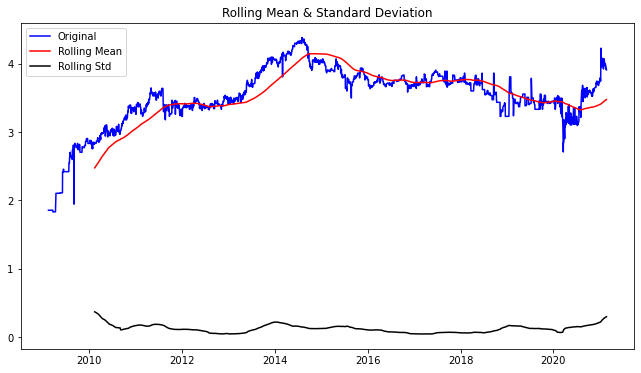

In [143]:
plot_rolling_statistics(data)

In [144]:
augmented_dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                   -3.794521
p-value                           0.002964
#Lags Used                       15.000000
Number of Observations Used    4377.000000
Critical Value (1%)              -3.431845
Critical Value (5%)              -2.862201
Critical Value (10%)             -2.567122
dtype: float64


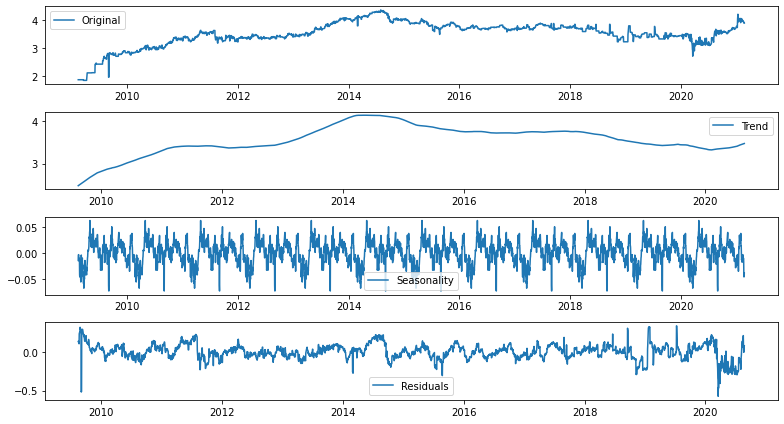

In [145]:
trend_data, seasonal_data, residual_data = seasonal_decomposed_data(data)

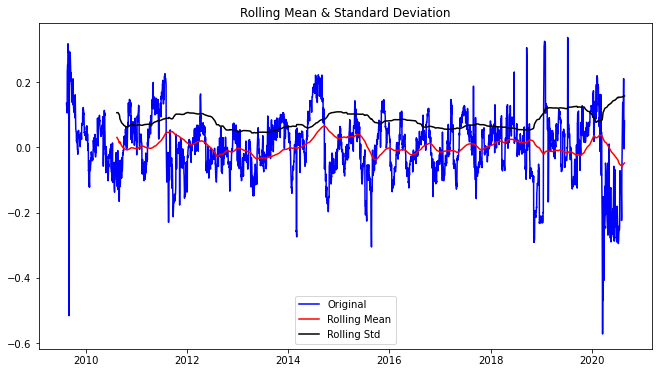

In [146]:
plot_rolling_statistics(residual_data)

In [147]:
augmented_dickey_fuller_test(residual_data)

Results of Dickey-Fuller Test:
Test Statistic                -7.352184e+00
p-value                        9.992795e-11
#Lags Used                     1.500000e+01
Number of Observations Used    4.013000e+03
Critical Value (1%)           -3.431981e+00
Critical Value (5%)           -2.862260e+00
Critical Value (10%)          -2.567154e+00
dtype: float64


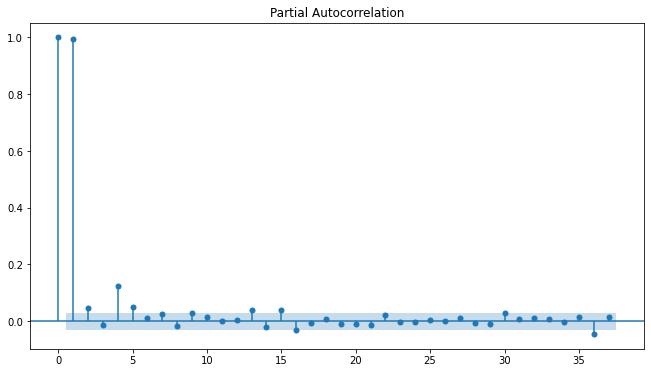

In [148]:
find_ARIMA_p(data)

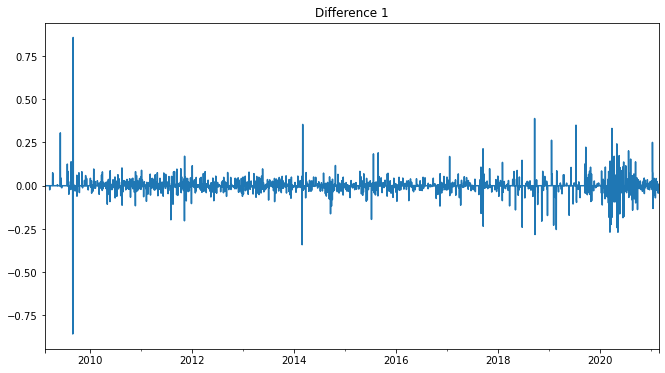

Results of Dickey-Fuller Test:
Test Statistic                  -20.495172
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    4377.000000
Critical Value (1%)              -3.431845
Critical Value (5%)              -2.862201
Critical Value (10%)             -2.567122
dtype: float64


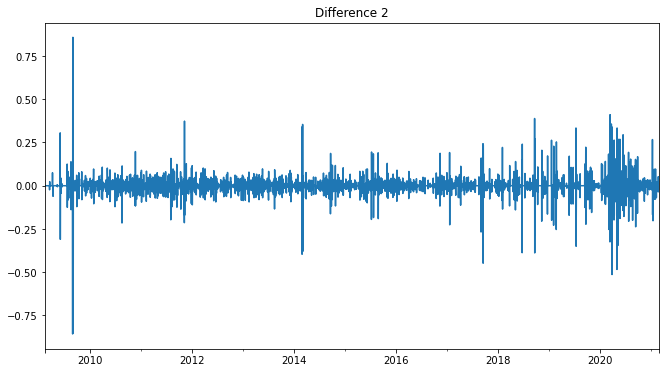

Results of Dickey-Fuller Test:
Test Statistic                  -20.302440
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4359.000000
Critical Value (1%)              -3.431851
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64


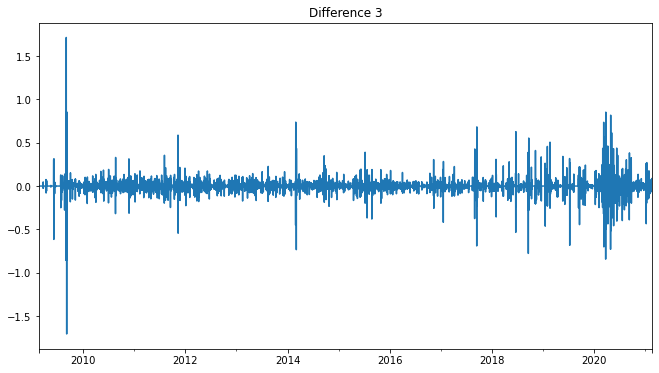

Results of Dickey-Fuller Test:
Test Statistic                  -27.913233
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4358.000000
Critical Value (1%)              -3.431851
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64


In [149]:
find_ARIMA_d(data)

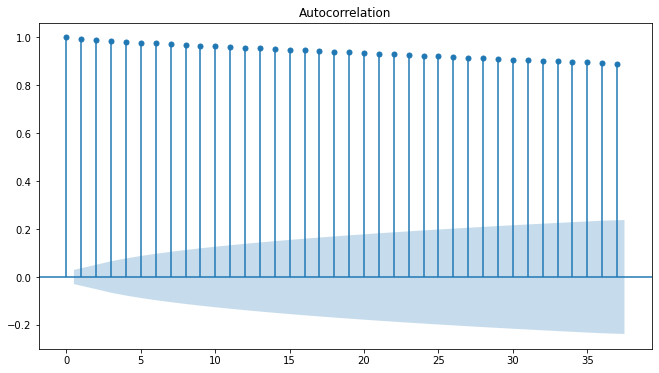

In [150]:
find_ARIMA_q(data)

훈련데이터 3953개, 시험데이터 440개


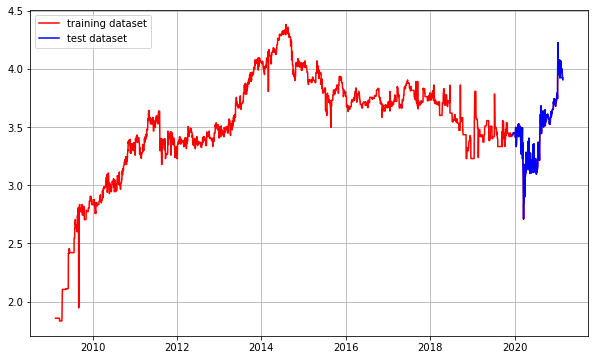

In [151]:
train_data, test_data = split_train_test(data)

/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3952
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7766.511
Method:                       css-mle   S.D. of innovations              0.034
Date:                Wed, 24 Feb 2021   AIC                         -15527.021
Time:                        14:30:05   BIC                         -15508.175
Sample:                    02-14-2009   HQIC                        -15520.337
                         - 12-10-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.001      0.750      0.453      -0.001       0.001
ar.L1.D.Close    -0.0221      0.016     -1.390      0.165      -0.053       0.009
                                    Root

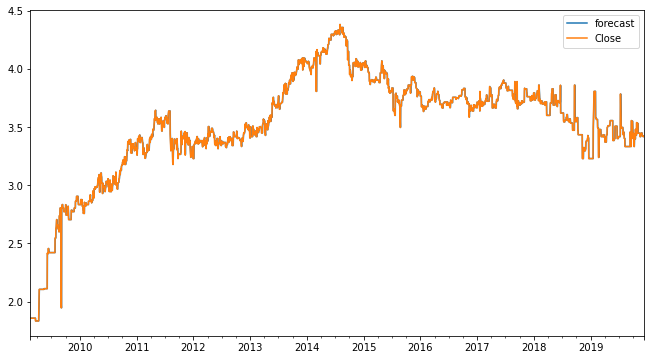

In [152]:
fitted_m = train_model(train_data, 1, 1, 0)

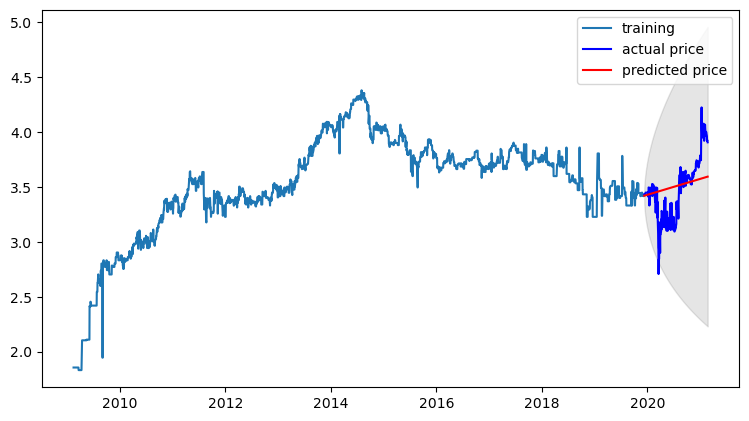

MSE:  71.24894113871761
MAE:  6.177097483579573
RMSE:  8.440908786304803
MAPE: 19.73%


In [153]:
show_predict(fitted_m, train_data, test_data, use_log)

## 한국전력

In [154]:
file = '015760.KS.csv' # 한국전력
use_log = True
data = load_data(file)

015760.KS.csv 파일을 불러왔습니다.
               Open     High      Low    Close     Adj Close     Volume
Date                                                                   
2000-01-04  35600.0  38500.0  34550.0  36000.0  24059.365234  2341000.0
2000-01-05  34500.0  35700.0  33500.0  34000.0  22722.736328  1681900.0
2000-01-06  36900.0  36900.0  34500.0  35000.0  23391.044922  2995600.0
2000-01-07  34500.0  38600.0  34200.0  36800.0  24594.017578  2708600.0
2000-01-10  37500.0  38000.0  36100.0  36600.0  24460.349609  1547700.0
...             ...      ...      ...      ...           ...        ...
2021-02-17  23650.0  24250.0  23550.0  23800.0  23800.000000  4178684.0
2021-02-18  23800.0  24150.0  23750.0  23750.0  23750.000000  2773702.0
2021-02-19  23800.0  24000.0  23150.0  23750.0  23750.000000  4901504.0
2021-02-22  23900.0  24550.0  23800.0  23850.0  23850.000000  5745162.0
2021-02-23  23800.0  23850.0  23500.0  23650.0  23650.000000  2721943.0

[5315 rows x 6 columns]


In [155]:
data = refine_data(data)
if use_log:
    data = np.log(data)

데이터를 조정하였습니다
                   Close
2000-01-04  36000.000000
2000-01-05  34000.000000
2000-01-06  35000.000000
2000-01-07  36800.000000
2000-01-08  36733.333333
2000-01-09  36666.666667
2000-01-10  36600.000000
2000-01-11  36300.000000
2000-01-12  36500.000000
2000-01-13  36000.000000


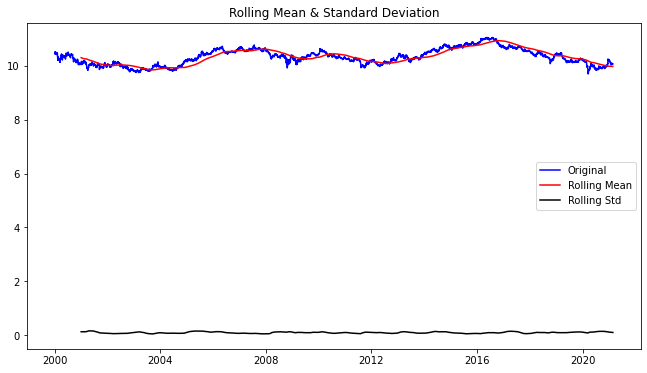

In [156]:
plot_rolling_statistics(data)

In [157]:
augmented_dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                   -2.160276
p-value                           0.220977
#Lags Used                        6.000000
Number of Observations Used    7715.000000
Critical Value (1%)              -3.431198
Critical Value (5%)              -2.861915
Critical Value (10%)             -2.566969
dtype: float64


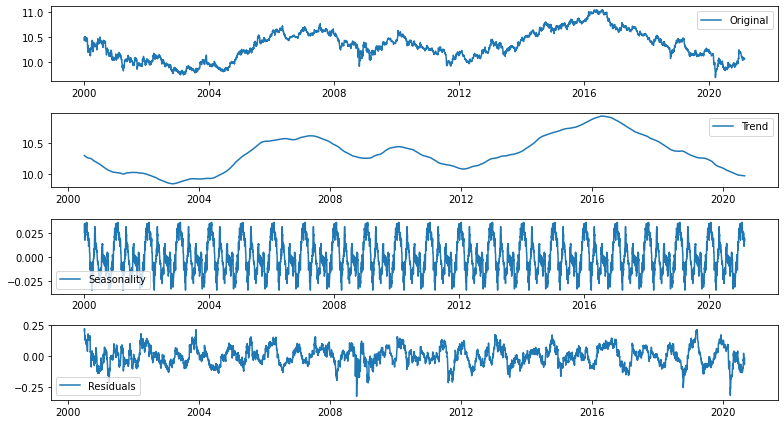

In [158]:
trend_data, seasonal_data, residual_data = seasonal_decomposed_data(data)

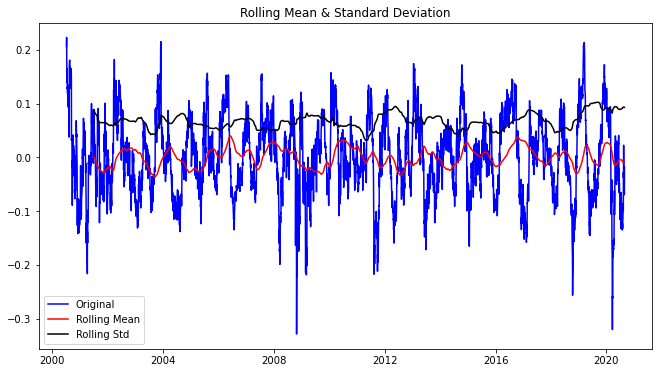

In [159]:
plot_rolling_statistics(residual_data)

In [160]:
augmented_dickey_fuller_test(residual_data)

Results of Dickey-Fuller Test:
Test Statistic                -9.054302e+00
p-value                        4.747120e-15
#Lags Used                     4.000000e+00
Number of Observations Used    7.353000e+03
Critical Value (1%)           -3.431240e+00
Critical Value (5%)           -2.861933e+00
Critical Value (10%)          -2.566979e+00
dtype: float64


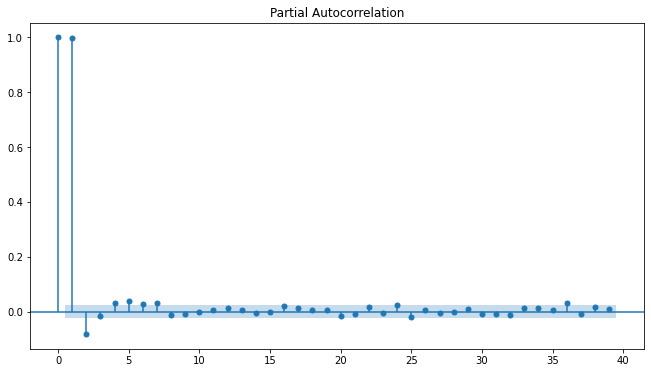

In [161]:
find_ARIMA_p(data)

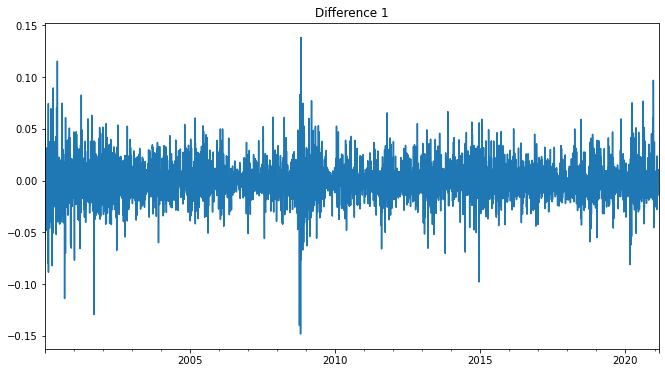

Results of Dickey-Fuller Test:
Test Statistic                  -38.658291
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    7715.000000
Critical Value (1%)              -3.431198
Critical Value (5%)              -2.861915
Critical Value (10%)             -2.566969
dtype: float64


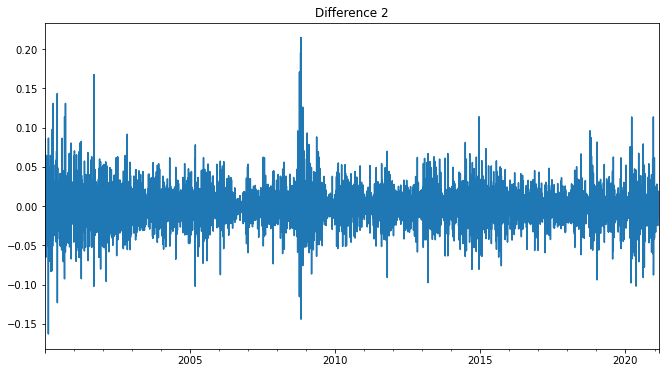

Results of Dickey-Fuller Test:
Test Statistic                  -24.999092
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7683.000000
Critical Value (1%)              -3.431201
Critical Value (5%)              -2.861916
Critical Value (10%)             -2.566970
dtype: float64


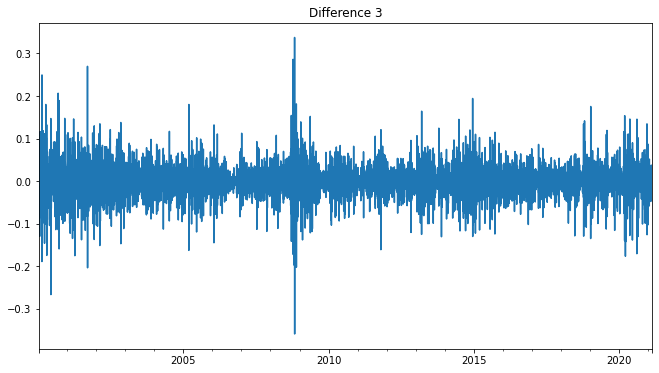

Results of Dickey-Fuller Test:
Test Statistic                  -32.977255
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7682.000000
Critical Value (1%)              -3.431202
Critical Value (5%)              -2.861916
Critical Value (10%)             -2.566970
dtype: float64


In [162]:
find_ARIMA_d(data)

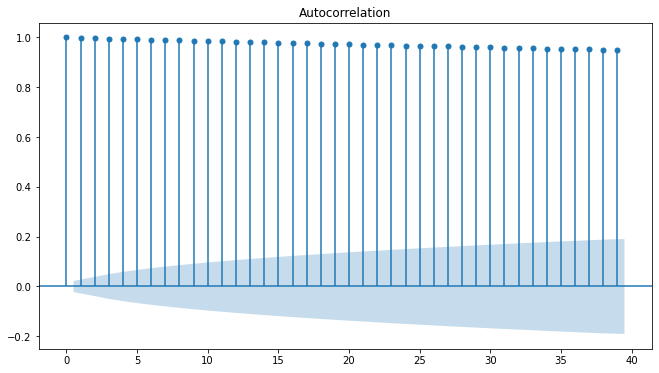

In [163]:
find_ARIMA_q(data)

훈련데이터 6949개, 시험데이터 773개


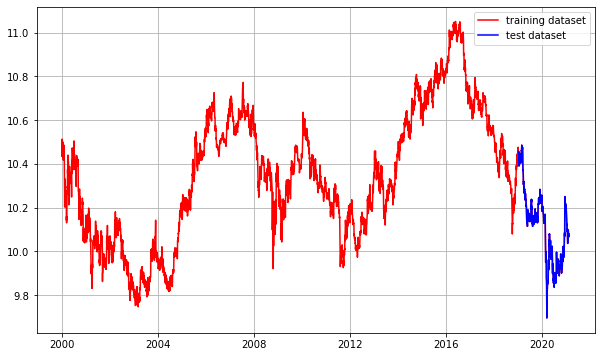

In [164]:
train_data, test_data = split_train_test(data)

/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6948
Model:                 ARIMA(1, 1, 0)   Log Likelihood               19304.881
Method:                       css-mle   S.D. of innovations              0.015
Date:                Wed, 24 Feb 2021   AIC                         -38603.761
Time:                        14:30:08   BIC                         -38583.223
Sample:                    01-05-2000   HQIC                        -38596.681
                         - 01-12-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.062e-06      0.000     -0.031      0.975      -0.000       0.000
ar.L1.D.Close     0.0850      0.012      7.108      0.000       0.062       0.108
                                    Root

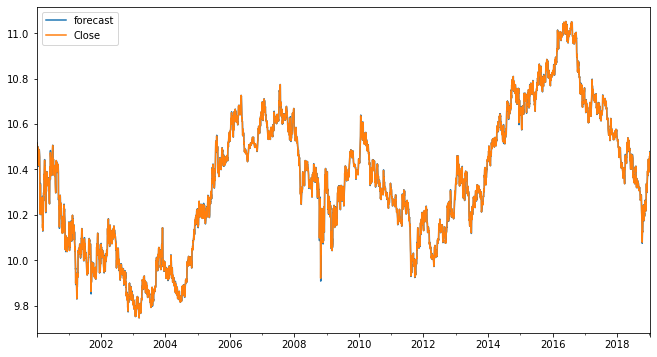

In [165]:
fitted_m = train_model(train_data, 1, 1, 0)

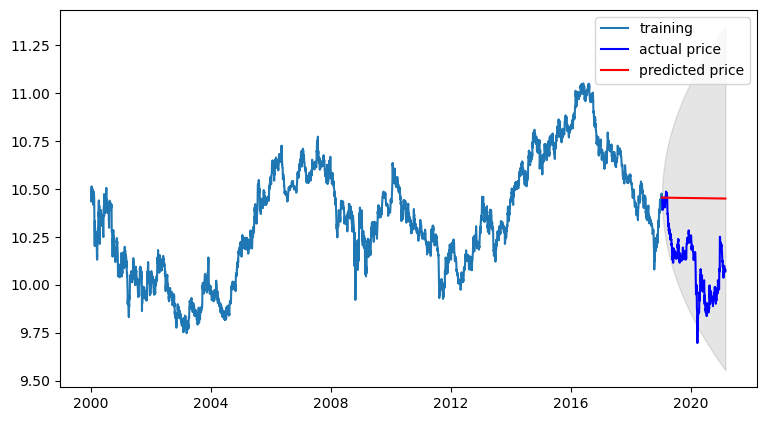

MSE:  110895422.52929501
MAE:  9709.02179258896
RMSE:  10530.68955621117
MAPE: 42.67%


In [166]:
show_predict(fitted_m, train_data, test_data, use_log)

## LG생활건강

In [167]:
file = '051900.KS.csv' # LG생활건강:좋음
use_log = False
data = load_data(file)

051900.KS.csv 파일을 불러왔습니다.
                 Open       High        Low      Close     Adj Close  \
Date                                                                   
2001-04-25    11900.0    13650.0    11900.0    13650.0  1.025250e+04   
2001-04-26    11900.0    13650.0    11900.0    13650.0  1.025250e+04   
2001-04-27    17950.0    17950.0    16600.0    17950.0  1.348222e+04   
2001-04-30    18900.0    19500.0    17500.0    18000.0  1.351978e+04   
2001-05-01    18000.0    18000.0    18000.0    18000.0  1.351978e+04   
...               ...        ...        ...        ...           ...   
2021-02-17  1628000.0  1635000.0  1601000.0  1616000.0  1.616000e+06   
2021-02-18  1633000.0  1633000.0  1596000.0  1596000.0  1.596000e+06   
2021-02-19  1618000.0  1618000.0  1575000.0  1600000.0  1.600000e+06   
2021-02-22  1620000.0  1620000.0  1561000.0  1561000.0  1.561000e+06   
2021-02-23  1565000.0  1592000.0  1560000.0  1585000.0  1.585000e+06   

               Volume  
Date         

In [168]:
data = refine_data(data)
if use_log:
    data = np.log(data)

데이터를 조정하였습니다
                   Close
2001-04-25  13650.000000
2001-04-26  13650.000000
2001-04-27  17950.000000
2001-04-28  17966.666667
2001-04-29  17983.333333
2001-04-30  18000.000000
2001-05-01  18000.000000
2001-05-02  20700.000000
2001-05-03  20250.000000
2001-05-04  18850.000000


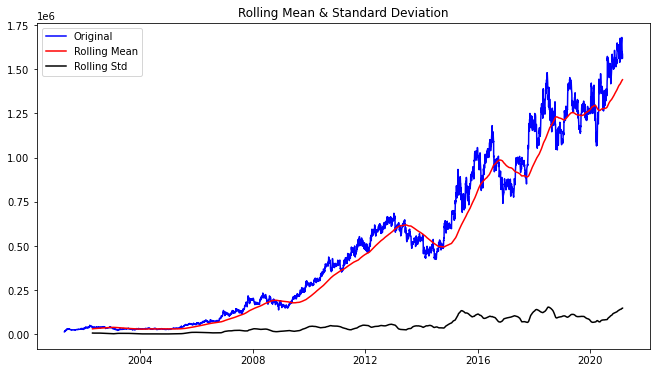

In [169]:
plot_rolling_statistics(data)

In [170]:
augmented_dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                    0.300686
p-value                           0.977376
#Lags Used                       29.000000
Number of Observations Used    7215.000000
Critical Value (1%)              -3.431257
Critical Value (5%)              -2.861941
Critical Value (10%)             -2.566983
dtype: float64


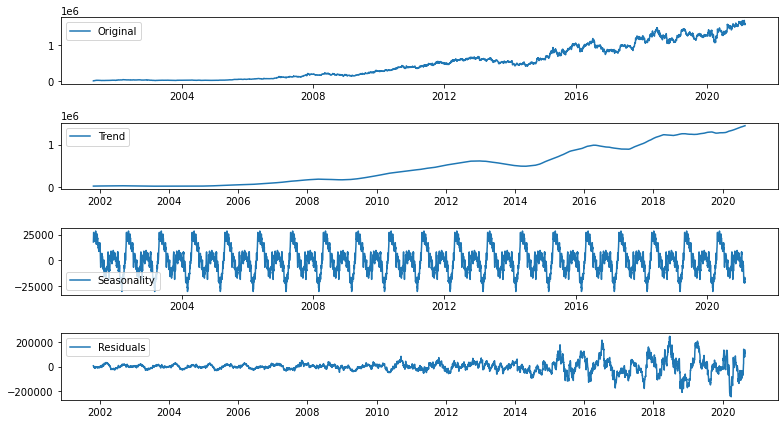

In [171]:
trend_data, seasonal_data, residual_data = seasonal_decomposed_data(data)

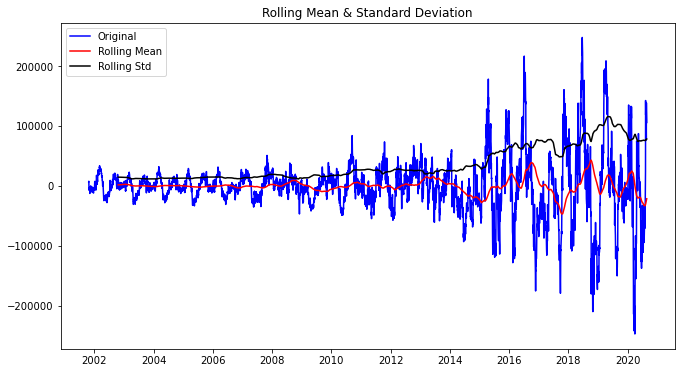

In [172]:
plot_rolling_statistics(residual_data)

In [173]:
augmented_dickey_fuller_test(residual_data)

Results of Dickey-Fuller Test:
Test Statistic                -1.021537e+01
p-value                        5.499395e-18
#Lags Used                     2.800000e+01
Number of Observations Used    6.852000e+03
Critical Value (1%)           -3.431305e+00
Critical Value (5%)           -2.861962e+00
Critical Value (10%)          -2.566995e+00
dtype: float64


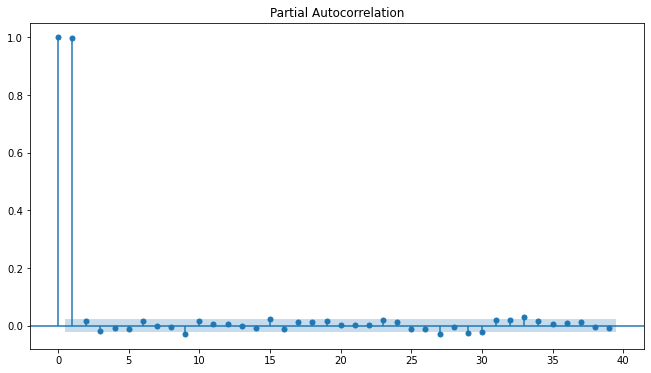

In [174]:
find_ARIMA_p(data)

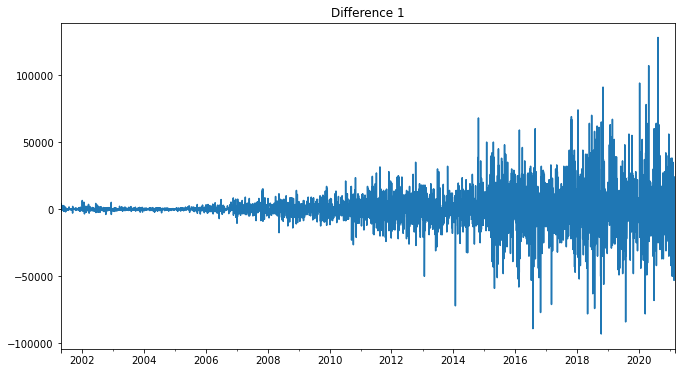

Results of Dickey-Fuller Test:
Test Statistic                -1.592225e+01
p-value                        7.899465e-29
#Lags Used                     2.800000e+01
Number of Observations Used    7.215000e+03
Critical Value (1%)           -3.431257e+00
Critical Value (5%)           -2.861941e+00
Critical Value (10%)          -2.566983e+00
dtype: float64


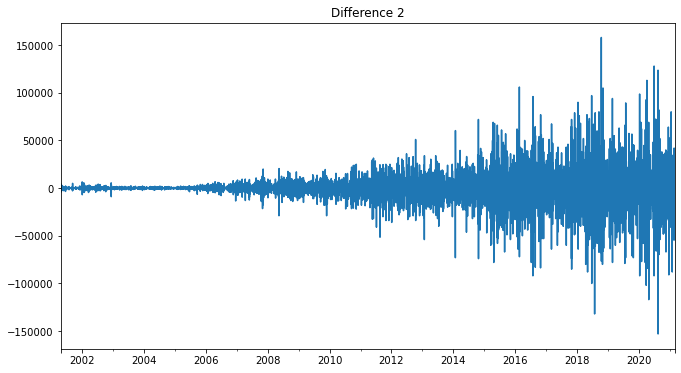

Results of Dickey-Fuller Test:
Test Statistic                  -23.460831
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7206.000000
Critical Value (1%)              -3.431258
Critical Value (5%)              -2.861941
Critical Value (10%)             -2.566984
dtype: float64


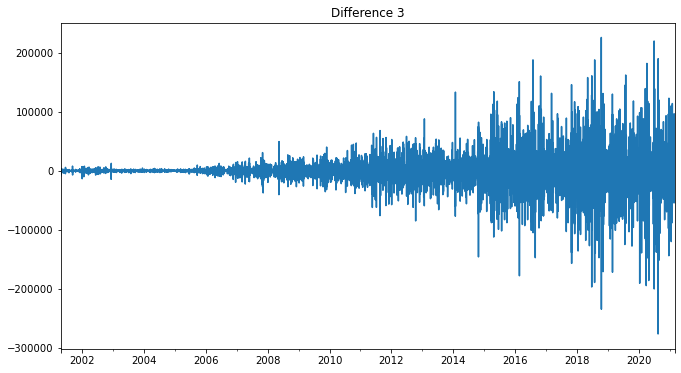

Results of Dickey-Fuller Test:
Test Statistic                  -33.190397
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7205.000000
Critical Value (1%)              -3.431258
Critical Value (5%)              -2.861941
Critical Value (10%)             -2.566984
dtype: float64


In [175]:
find_ARIMA_d(data)

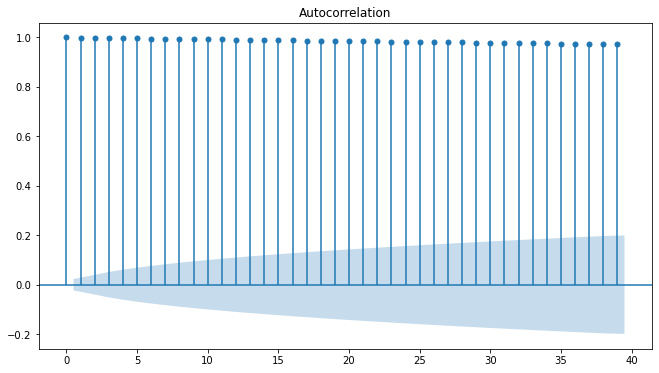

In [176]:
find_ARIMA_q(data)

훈련데이터 6520개, 시험데이터 725개


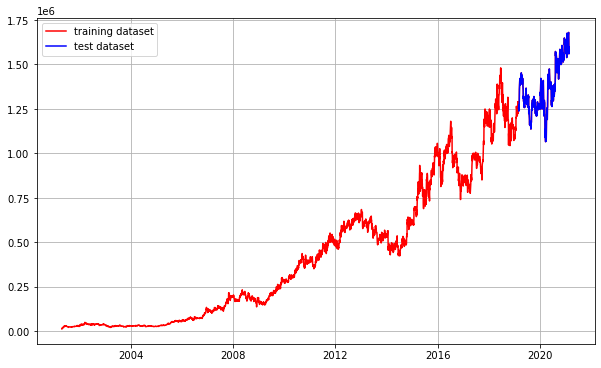

In [177]:
train_data, test_data = split_train_test(data)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6519
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -68866.188
Method:                       css-mle   S.D. of innovations           9367.303
Date:                Wed, 24 Feb 2021   AIC                         137738.376
Time:                        14:30:11   BIC                         137758.724
Sample:                    04-26-2001   HQIC                        137745.413
                         - 03-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           189.6917    114.813      1.652      0.098     -35.338     414.722
ar.L1.D.Close    -0.0105      0.012     -0.847      0.397      -0.035       0.014
                                    Root

/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


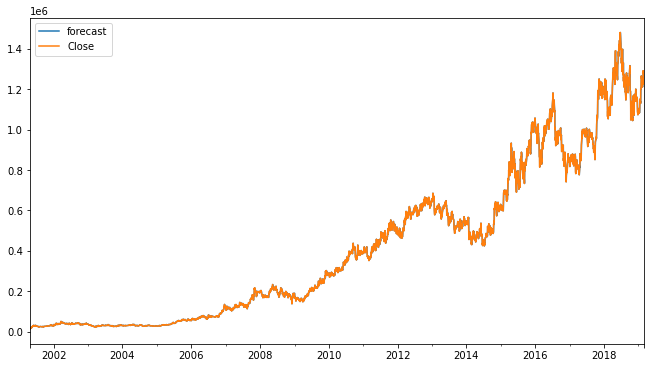

In [178]:
fitted_m = train_model(train_data, 1, 1, 0)

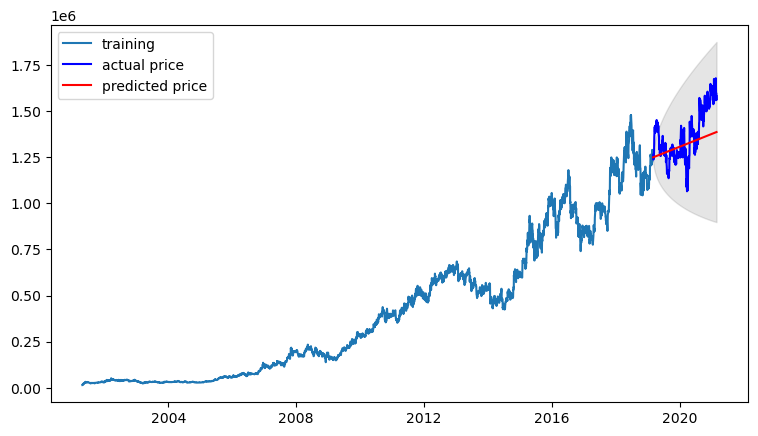

MSE:  15419112031.438238
MAE:  98857.7929834525
RMSE:  124173.71715237584
MAPE: 6.99%


In [179]:
show_predict(fitted_m, train_data, test_data, use_log)

## 해태제과

In [180]:
file = '101530.KS.csv' # 해태제과: 좋음
use_log = True
data = load_data(file)

101530.KS.csv 파일을 불러왔습니다.
               Open     High      Low    Close     Adj Close     Volume
Date                                                                   
2016-05-11  18950.0  24600.0  18000.0  24600.0  23268.564453  8773781.0
2016-05-12  29550.0  31950.0  29500.0  31950.0  30220.757813  1757878.0
2016-05-13  41500.0  41500.0  40950.0  41500.0  39253.882813  1221061.0
2016-05-16  49750.0  53900.0  45000.0  53800.0  50888.160156  7695596.0
2016-05-17  51500.0  68000.0  48000.0  60000.0  56752.593750  7132160.0
...             ...      ...      ...      ...           ...        ...
2021-02-17   8880.0   8880.0   8720.0   8840.0   8840.000000    53701.0
2021-02-18   8830.0   8840.0   8600.0   8700.0   8700.000000    45542.0
2021-02-19   8650.0   8650.0   8450.0   8600.0   8600.000000    34580.0
2021-02-22   8600.0   8640.0   8530.0   8620.0   8620.000000    25780.0
2021-02-23   8610.0   8620.0   8440.0   8470.0   8470.000000    34097.0

[1175 rows x 6 columns]


In [181]:
data = refine_data(data)
if use_log:
    data = np.log(data)

데이터를 조정하였습니다
              Close
2016-05-11  24600.0
2016-05-12  31950.0
2016-05-13  41500.0
2016-05-14  45600.0
2016-05-15  49700.0
2016-05-16  53800.0
2016-05-17  60000.0
2016-05-18  49200.0
2016-05-19  49150.0
2016-05-20  46150.0


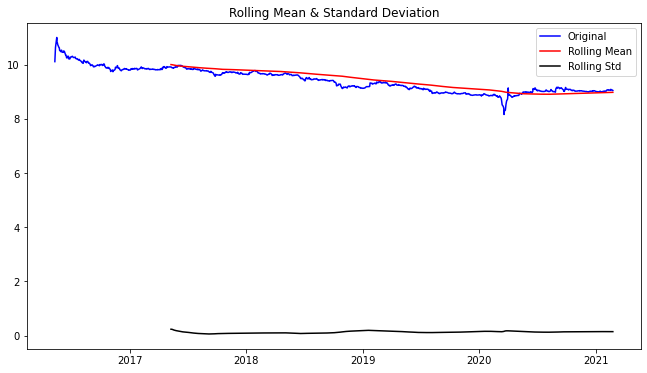

In [182]:
plot_rolling_statistics(data)

In [183]:
augmented_dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                   -2.868446
p-value                           0.049142
#Lags Used                       14.000000
Number of Observations Used    1735.000000
Critical Value (1%)              -3.434125
Critical Value (5%)              -2.863207
Critical Value (10%)             -2.567658
dtype: float64


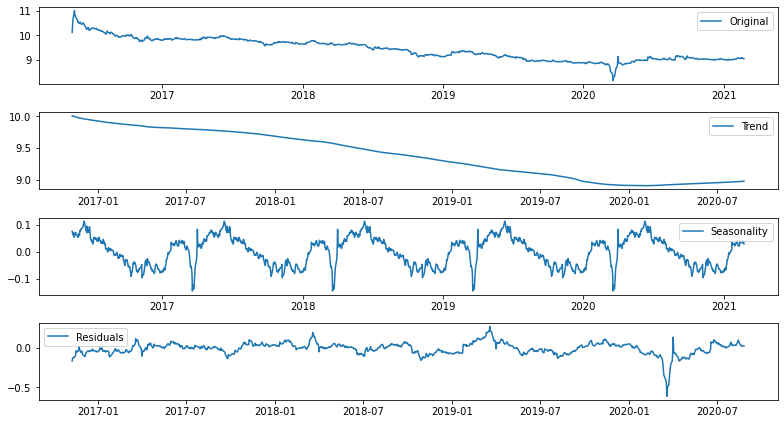

In [184]:
trend_data, seasonal_data, residual_data = seasonal_decomposed_data(data)

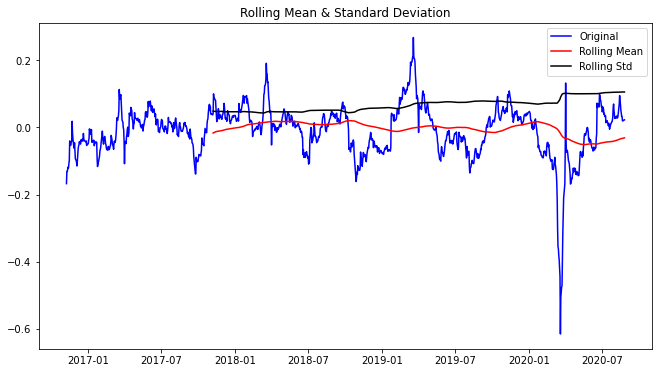

In [185]:
plot_rolling_statistics(residual_data)

In [186]:
augmented_dickey_fuller_test(residual_data)

Results of Dickey-Fuller Test:
Test Statistic                   -3.790602
p-value                           0.003005
#Lags Used                       14.000000
Number of Observations Used    1371.000000
Critical Value (1%)              -3.435129
Critical Value (5%)              -2.863650
Critical Value (10%)             -2.567894
dtype: float64


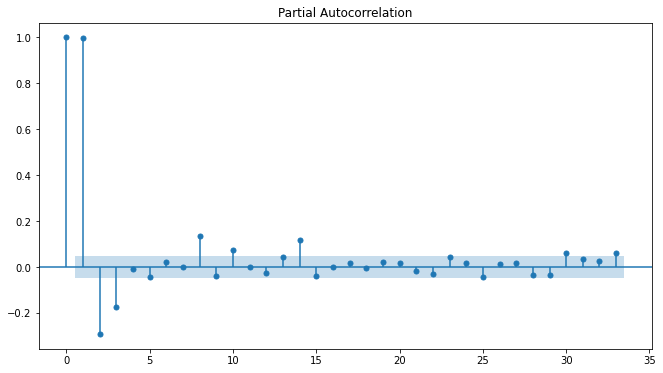

In [187]:
find_ARIMA_p(data)

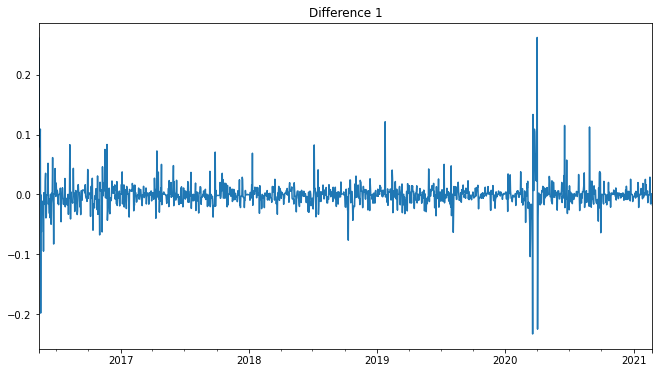

Results of Dickey-Fuller Test:
Test Statistic                -1.397631e+01
p-value                        4.255604e-26
#Lags Used                     1.300000e+01
Number of Observations Used    1.735000e+03
Critical Value (1%)           -3.434125e+00
Critical Value (5%)           -2.863207e+00
Critical Value (10%)          -2.567658e+00
dtype: float64


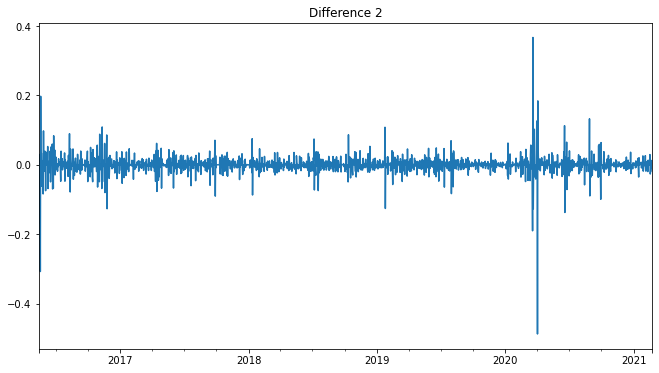

Results of Dickey-Fuller Test:
Test Statistic                -1.577895e+01
p-value                        1.137245e-28
#Lags Used                     2.500000e+01
Number of Observations Used    1.722000e+03
Critical Value (1%)           -3.434153e+00
Critical Value (5%)           -2.863220e+00
Critical Value (10%)          -2.567664e+00
dtype: float64


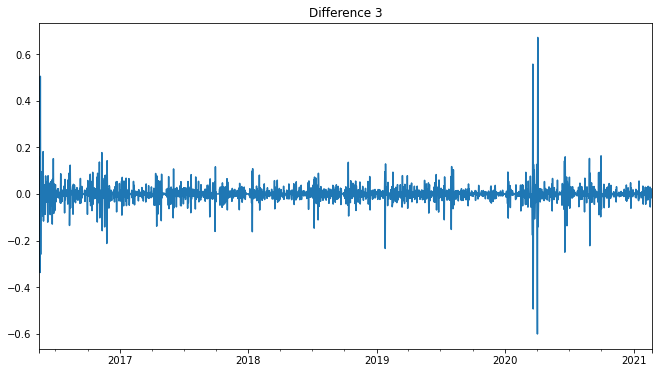

Results of Dickey-Fuller Test:
Test Statistic                -1.830013e+01
p-value                        2.287528e-30
#Lags Used                     2.500000e+01
Number of Observations Used    1.721000e+03
Critical Value (1%)           -3.434155e+00
Critical Value (5%)           -2.863221e+00
Critical Value (10%)          -2.567665e+00
dtype: float64


In [188]:
find_ARIMA_d(data)

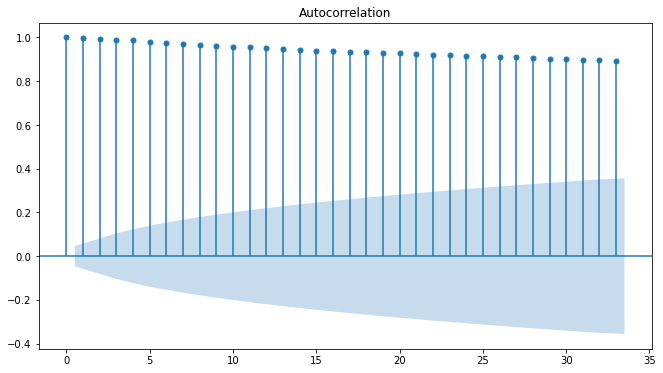

In [189]:
find_ARIMA_q(data)

훈련데이터 1575개, 시험데이터 175개


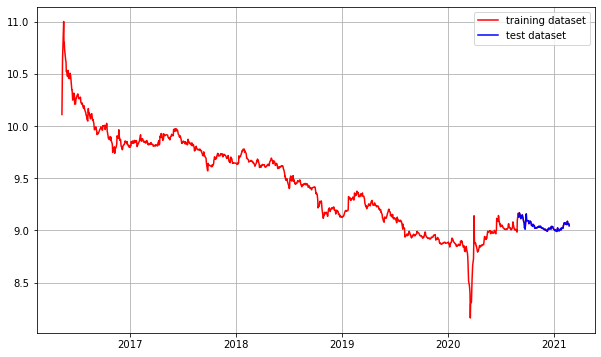

In [190]:
train_data, test_data = split_train_test(data)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1574
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3715.909
Method:                       css-mle   S.D. of innovations              0.023
Date:                Wed, 24 Feb 2021   AIC                          -7425.819
Time:                        14:30:14   BIC                          -7409.735
Sample:                    05-12-2016   HQIC                         -7419.841
                         - 09-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0006      0.001     -0.810      0.418      -0.002       0.001
ar.L1.D.Close     0.1880      0.026      7.272      0.000       0.137       0.239
                                    Root

/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


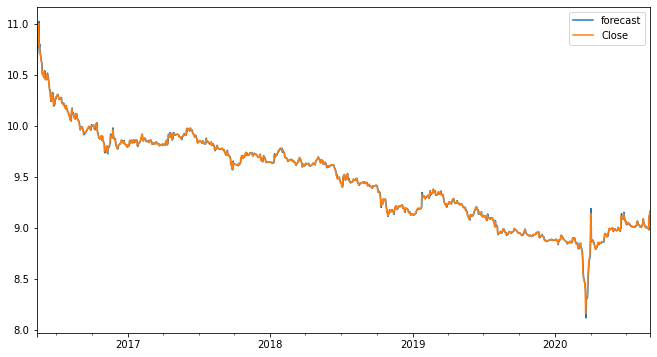

In [191]:
fitted_m = train_model(train_data, 1, 1, 0)

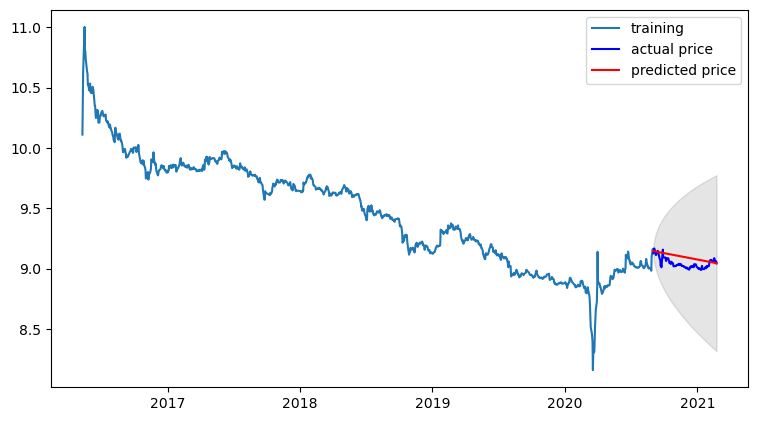

MSE:  280793.93376391294
MAE:  472.78038716070336
RMSE:  529.8999280655858
MAPE: 5.66%


In [192]:
show_predict(fitted_m, train_data, test_data, use_log)

## 우리금융지주

In [193]:
file = '316140.KS.csv' # 우리금융지주 : 좋음
use_log = True
data = load_data(file)

316140.KS.csv 파일을 불러왔습니다.
               Open     High      Low    Close     Adj Close     Volume
Date                                                                   
2019-02-21  15200.0  15250.0  15050.0  15100.0  14237.142578   883514.0
2019-02-22  14950.0  15000.0  14750.0  14850.0  14001.428711  1546763.0
2019-02-25  14900.0  15050.0  14850.0  14900.0  14048.571289   905856.0
2019-02-26  14900.0  14950.0  14700.0  14700.0  13860.000000   890582.0
2019-02-27  14650.0  14850.0  14500.0  14800.0  13954.286133  1573961.0
...             ...      ...      ...      ...           ...        ...
2021-02-17   9630.0   9750.0   9570.0   9580.0   9580.000000  1924023.0
2021-02-18   9550.0   9610.0   9450.0   9450.0   9450.000000  1289629.0
2021-02-19   9410.0   9590.0   9380.0   9590.0   9590.000000  1234105.0
2021-02-22   9610.0   9680.0   9560.0   9590.0   9590.000000  1681477.0
2021-02-23   9690.0   9700.0   9590.0   9600.0   9600.000000  1436415.0

[496 rows x 6 columns]


In [194]:
data = refine_data(data)
if use_log:
    data = np.log(data)

데이터를 조정하였습니다
                   Close
2019-02-21  15100.000000
2019-02-22  14850.000000
2019-02-23  14866.666667
2019-02-24  14883.333333
2019-02-25  14900.000000
2019-02-26  14700.000000
2019-02-27  14800.000000
2019-02-28  14800.000000
2019-03-01  14700.000000
2019-03-02  14600.000000


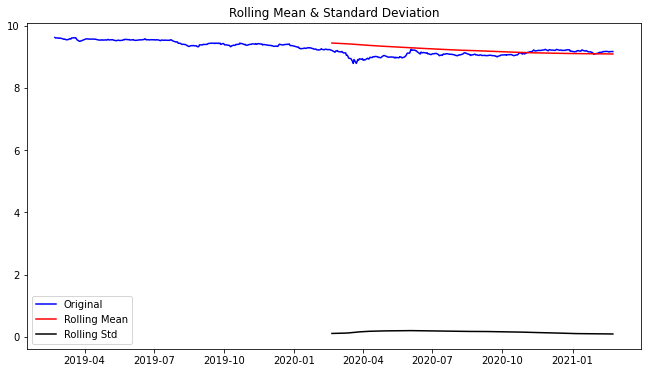

In [195]:
plot_rolling_statistics(data)

In [196]:
augmented_dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                  -1.511229
p-value                          0.527949
#Lags Used                      15.000000
Number of Observations Used    718.000000
Critical Value (1%)             -3.439490
Critical Value (5%)             -2.865574
Critical Value (10%)            -2.568918
dtype: float64


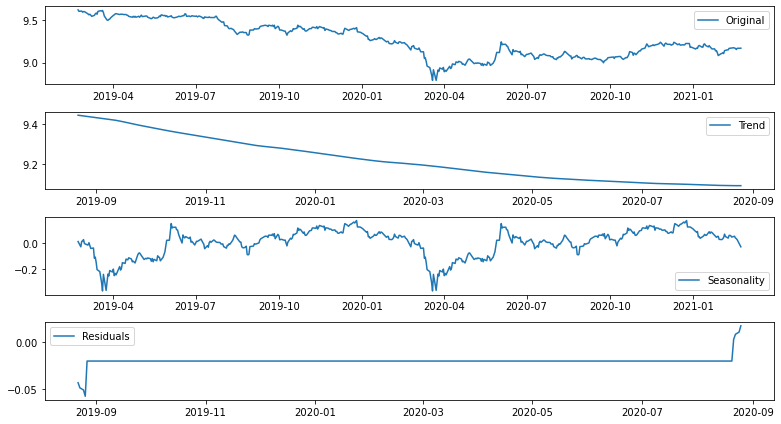

In [197]:
trend_data, seasonal_data, residual_data = seasonal_decomposed_data(data)

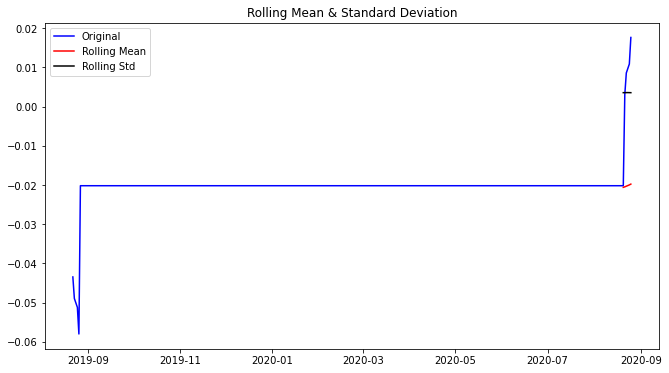

In [198]:
plot_rolling_statistics(residual_data)

In [199]:
augmented_dickey_fuller_test(residual_data)

Results of Dickey-Fuller Test:
Test Statistic                  -5.392238
p-value                          0.000004
#Lags Used                       3.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


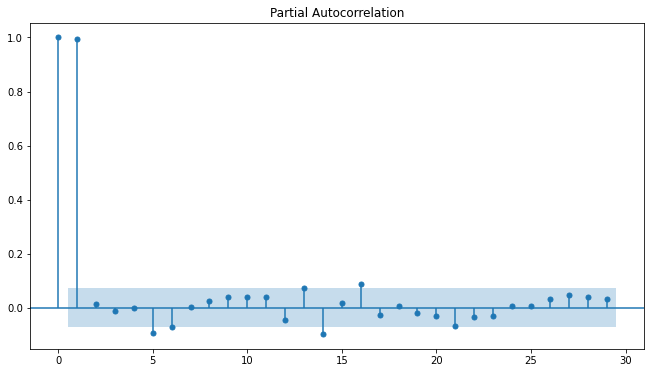

In [200]:
find_ARIMA_p(data)

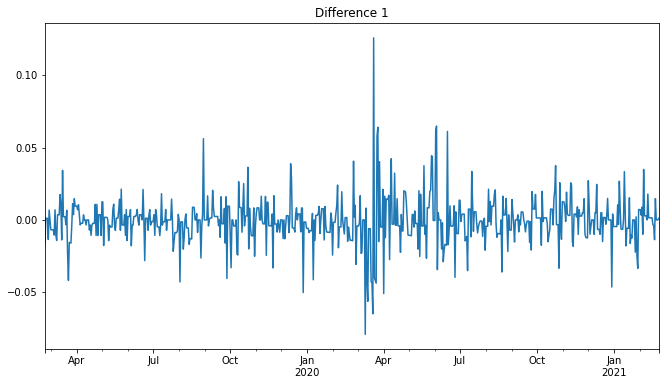

Results of Dickey-Fuller Test:
Test Statistic                -7.350244e+00
p-value                        1.010431e-10
#Lags Used                     1.400000e+01
Number of Observations Used    7.180000e+02
Critical Value (1%)           -3.439490e+00
Critical Value (5%)           -2.865574e+00
Critical Value (10%)          -2.568918e+00
dtype: float64


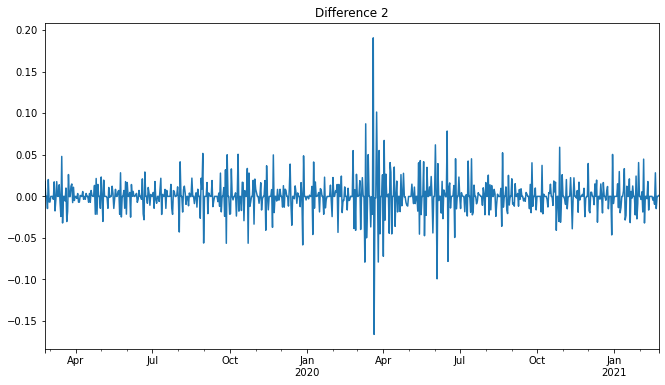

Results of Dickey-Fuller Test:
Test Statistic                -1.116218e+01
p-value                        2.770415e-20
#Lags Used                     1.900000e+01
Number of Observations Used    7.120000e+02
Critical Value (1%)           -3.439568e+00
Critical Value (5%)           -2.865608e+00
Critical Value (10%)          -2.568936e+00
dtype: float64


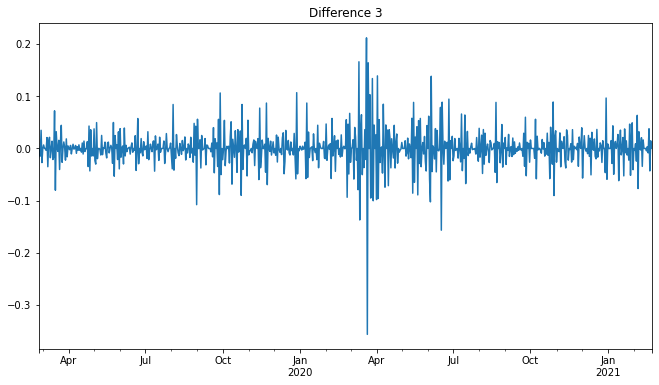

Results of Dickey-Fuller Test:
Test Statistic                -1.263751e+01
p-value                        1.459079e-23
#Lags Used                     2.000000e+01
Number of Observations Used    7.100000e+02
Critical Value (1%)           -3.439594e+00
Critical Value (5%)           -2.865619e+00
Critical Value (10%)          -2.568942e+00
dtype: float64


In [201]:
find_ARIMA_d(data)

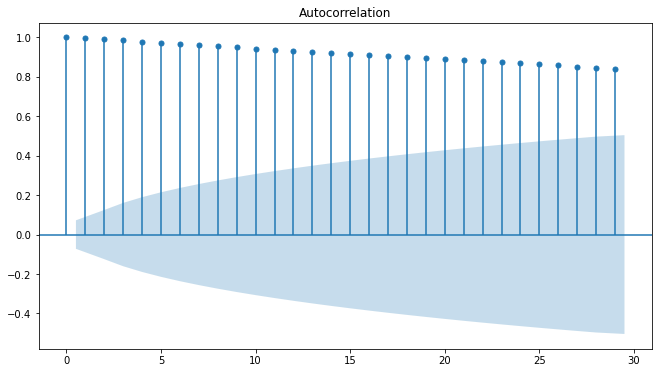

In [202]:
find_ARIMA_q(data)

훈련데이터 660개, 시험데이터 74개


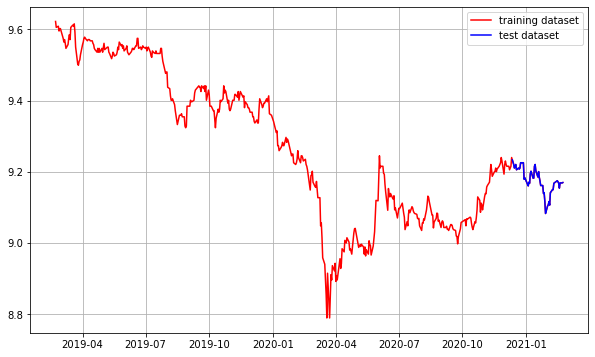

In [203]:
train_data, test_data = split_train_test(data)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  659
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1802.258
Method:                       css-mle   S.D. of innovations              0.016
Date:                Wed, 24 Feb 2021   AIC                          -3598.515
Time:                        14:30:16   BIC                          -3585.043
Sample:                    02-22-2019   HQIC                         -3593.293
                         - 12-11-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0006      0.001     -0.939      0.348      -0.002       0.001
ar.L1.D.Close     0.0105      0.039      0.268      0.789      -0.066       0.087
                                    Root

/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


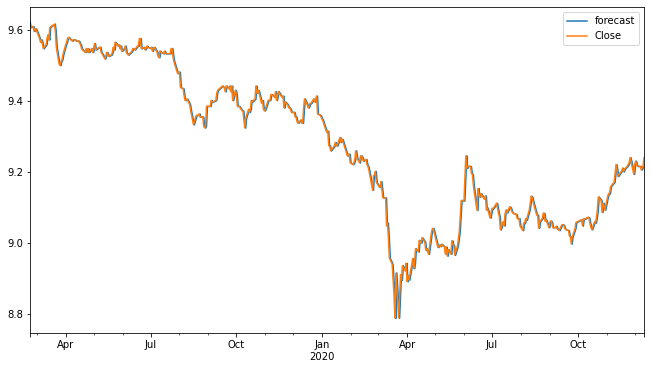

In [204]:
fitted_m = train_model(train_data, 1, 1, 0)

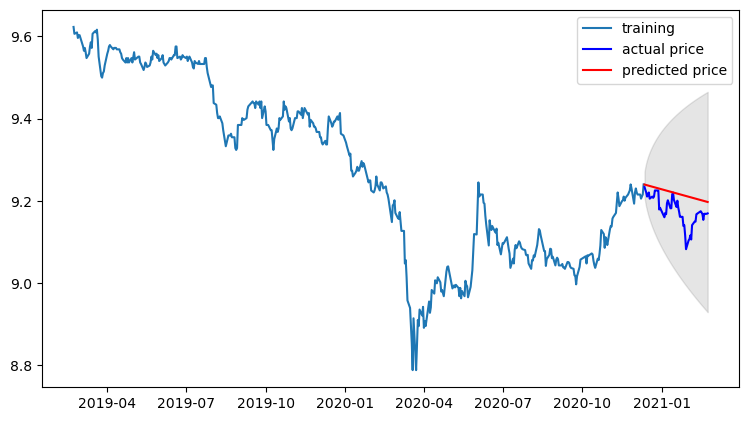

MSE:  247909.8014855549
MAE:  417.1146751772272
RMSE:  497.905414195864
MAPE: 4.42%


In [205]:
show_predict(fitted_m, train_data, test_data, use_log)

# 결론

In [206]:
file = 'HYMTF.csv' # 현대차
# file = '005930.KS.csv' # 삼성전자
file = '004990.KS.csv' # 롯데지주
file = '000080.KS.csv' # 하이트진로
file = '015760.KS.csv' # 한국전력
file = '051900.KS.csv' # LG생활건강:좋음
# file = '105560.KS.csv' # KB금융지주
# file = '000150.KS.csv' # 두산
# file = '009540.KS.csv' # 현대중공업
# file = '103140.KS.csv' # 풍산
file = '018250.KS.csv' # 애경
file = '000720.KS.csv' # 현대건설
file = '004090.KS.csv' # 한국석유공사
file = '005300.KS.csv' # 롯데칠성음료
file = '008770.KS.csv' # 신라호텔
file = '042660.KS.csv' # 대우조선해양
file = '004170.KS.csv' # 신세계
file = '018260.KS.csv' # 삼성SDS
file = '101530.KS.csv' # 해태제과: 좋음
file = '003230.KS.csv' # 삼양식품
file = '001040.KS.csv' # CJ
file = '090430.KS.csv' # 아모레퍼시픽
file = '108670.KS.csv' # LG하우시스
file = '024110.KS.csv' # 기업은행
file = '316140.KS.csv' # 우리금융지주 : 좋음
file = '002380.KS.csv' # KCC
file = '007310.KS.csv' # 오뚜기
file = '111770.KS.csv' # 영원무역
file = '010130.KS.csv' # 고려아연
file = '192400.KS.csv' # 쿠쿠홀딩스

사용된 주식 종목은 위와 같다.   
위 종목 중 MAPE 8%의 정확도로 예측된 종목은 LG생활건강, 해태제과, 우리금융지주였다.   

주식은 구간내 반복되는 경향이 매우 적고, 상승 하강의 패턴이 있어보여도 그 기간이 매우 달라 어떤 기간을 설정하더라도 seasonal보다 residual이 더 큰 경향을 보였다.   
이로 볼 때 seasonal 특성이 없다고 볼 수 있고 예측은 trend를 반영하여 이루어졌다.   

ARIMA의 p, d, q도 각각 1, 1, 0이 가장 좋았고 대부분 q를 증기시키면 오류가 발생했다.   
MAPE 8%의 결과가 나온 종목을 보면 대체로 최근 주식가격의 흐름이 전체 흐름과 일치하고, 등락폭이 상대적으로 적은 모습을 보였다.   
일부 전체적인 주가 흐름과 취근 흐름이 일치하여도 등락폭이 커 상대적으로 오차가 큰 종목이 있었다.   